In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from seiz_eeg.dataset import EEGDataset
from sklearn.metrics import f1_score, recall_score, precision_score

In [30]:
data_path = "data/"  # Replace with your data root path
DATA_ROOT = Path(data_path)
sample_rate = 250
segment_length = 3000

In [38]:
def create_spectrogram(x: np.ndarray):
    spectrograms = []
    for i in range(x.shape[1]):
        f, t, Sxx = signal.spectrogram(
            x[:, i], fs=sample_rate,
            nperseg=128, noverlap=96
        )
        # Keep only to 30 Hz
        mask = (f <= 30)
        Sxx = Sxx[mask, :]
        Sxx = np.log(Sxx + 1e-8)  # Log transform
        spectrograms.append(Sxx)
    spec_array = np.stack(spectrograms, axis=0)
    return torch.tensor(spec_array, dtype=torch.float32)

In [39]:
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
clips_te = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

In [40]:
train_dataset = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=create_spectrogram,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

In [41]:
test_dataset = EEGDataset(
    clips_te,
    signals_root=DATA_ROOT / "test",
    signal_transform=create_spectrogram,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    return_id=True,
)

In [42]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [43]:
class SpectrogramCNN(nn.Module):
    def __init__(self, in_channels=19):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(self.net(x))


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpectrogramCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
train_losses = []
val_f1s = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)  # [B, 19, F, T]
        yb = yb.float().unsqueeze(1).to(device) # [B, 1]

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

Epoch 1/50 - Loss: 0.3926
Epoch 2/50 - Loss: 0.3194
Epoch 3/50 - Loss: 0.2852
Epoch 4/50 - Loss: 0.2586
Epoch 5/50 - Loss: 0.2437
Epoch 6/50 - Loss: 0.2337
Epoch 7/50 - Loss: 0.2120
Epoch 8/50 - Loss: 0.2109
Epoch 9/50 - Loss: 0.2048
Epoch 10/50 - Loss: 0.2043
Epoch 11/50 - Loss: 0.1921
Epoch 12/50 - Loss: 0.1824
Epoch 13/50 - Loss: 0.1776
Epoch 14/50 - Loss: 0.1710
Epoch 15/50 - Loss: 0.1664
Epoch 16/50 - Loss: 0.1578
Epoch 17/50 - Loss: 0.1574
Epoch 18/50 - Loss: 0.1551
Epoch 19/50 - Loss: 0.1502
Epoch 20/50 - Loss: 0.1494
Epoch 21/50 - Loss: 0.1387
Epoch 22/50 - Loss: 0.1598
Epoch 23/50 - Loss: 0.1271
Epoch 24/50 - Loss: 0.1242
Epoch 25/50 - Loss: 0.1167
Epoch 26/50 - Loss: 0.1138
Epoch 27/50 - Loss: 0.1033
Epoch 28/50 - Loss: 0.1079
Epoch 29/50 - Loss: 0.1004
Epoch 30/50 - Loss: 0.0984
Epoch 31/50 - Loss: 0.0952
Epoch 32/50 - Loss: 0.0840
Epoch 33/50 - Loss: 0.0836
Epoch 34/50 - Loss: 0.0787
Epoch 35/50 - Loss: 0.0787
Epoch 36/50 - Loss: 0.0748
Epoch 37/50 - Loss: 0.0714
Epoch 38/5

KeyboardInterrupt: 

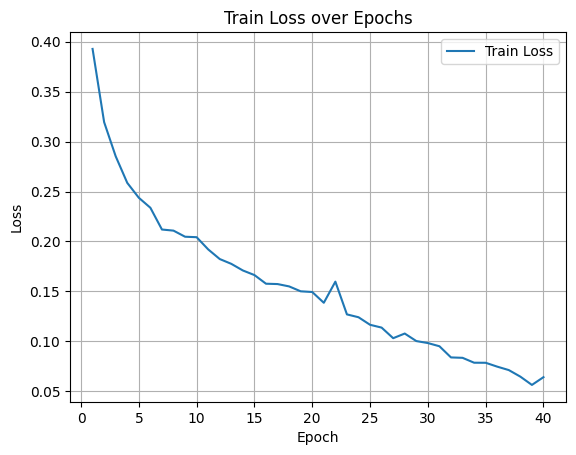

In [45]:
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
import re
# Generate the submission file for Kaggle

# Set the model to evaluation mode
model.eval()

# Lists to store sample IDs and predictions
all_predictions = []
all_ids = []

# Disable gradient computation for inference
with torch.no_grad():
    for xb, ids in test_loader:
        # Move the input data to the device (GPU or CPU)
        xb = xb.float().to(device)

        # Perform the forward pass to get the model's output logits
        logits = model(xb)

        # Convert logits to predictions.
        # For binary classification, threshold logits at 0 (adjust this if you use softmax or multi-class).
        predictions = (logits > 0).int().cpu().numpy()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float().int().cpu().numpy()

        # Append predictions and corresponding IDs to the lists
        all_predictions.extend(predictions.flatten().tolist())
        new_ids = []
        for sub_id in ids:
            # Step 1: Replace triple underscores with a unique placeholder
            sub_id = sub_id.replace("___", "<<<UNDERSCORE>>>")

            # Step 2: Remove all single underscores
            sub_id = sub_id.replace("_", "")

            # Step 3: Restore the placeholders as single underscores
            sub_id = sub_id.replace("<<<UNDERSCORE>>>", "_")
            new_ids.append(sub_id)
        all_ids.extend(new_ids)

# Create a DataFrame for Kaggle submission with the required format: "id,label"
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})

# Save the DataFrame to a CSV file without an index
submission_df.to_csv("submission.csv", index=False)
print("Kaggle submission file generated: submission.csv")

Kaggle submission file generated: submission.csv
